# Libraries and Global Parameters

In [1]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.9 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from glob import glob
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torch.multiprocessing as mp
from google.colab import drive
drive.mount('/content/drive')

# Set start method for multiprocessing to 'spawn'
mp.set_start_method('spawn', force=True)

# Define paths and load the dataset
file_path_0 = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset0"
annotations_path = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/annotations.csv"

# Getting list of image files from subset0
file_list_0 = glob(file_path_0 + "/*.mhd")
file_list = list(set(file_list_0))

# Function to correctly extract series UID from filename
def get_filename(file_list, case):
    for f in file_list:
        if case in os.path.basename(f):
            return f
    return None

# Load annotations
df_node = pd.read_csv(annotations_path)

# Extract series UIDs from filenames
series_uids_from_files = [os.path.basename(f).split('.')[0] for f in file_list]
print("Sample series UIDs from filenames:", series_uids_from_files[:5])

# Verify series UID compatibility
unique_seriesuid_annotations = df_node['seriesuid'].nunique()
unique_seriesuid_images = len(set(series_uids_from_files))

print("Unique series UID in annotations:", unique_seriesuid_annotations)
print("Unique series UID in image files:", unique_seriesuid_images)

# Map the series UID to file names
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna(subset=["file"])  # Drop rows where file mapping is not found

print("Annotations with associated files:", df_node.shape[0])
print(df_node.head())

# Define DataFrame columns
columns = ["seriesuid", "sliceindex", "imagedata", "bbox", "class"]
data = []

# Define target size for downsampling
target_size = (256, 256)

# Function to convert 3D center and diameter to 2D bounding box
def convert_to_2d_bounding_box(center, diam, spacing, origin):
    v_center = (center[:2] - origin[:2]) / spacing[:2]  # Only X, Y coordinates
    diam_pixels = diam / spacing[:2]
    x_min = int(v_center[0] - diam_pixels[0] / 2)
    x_max = int(v_center[0] + diam_pixels[0] / 2)
    y_min = int(v_center[1] - diam_pixels[1] / 2)
    y_max = int(v_center[1] + diam_pixels[1] / 2)
    return [x_min, y_min, x_max, y_max]

# Function to load images and determine if they contain nodules
def load_images_with_nodules(file_list, annotations_df, target_size=(256, 256)):
    data = []
    for img_file in tqdm(file_list):
        mini_df = annotations_df[annotations_df["file"] == img_file]
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())
        original_size = img_array.shape[1:3]

        if mini_df.shape[0] > 0:
            for _, row in mini_df.iterrows():
                node_x, node_y, node_z = row["coordX"], row["coordY"], row["coordZ"]
                diam = row["diameter_mm"]
                center = np.array([node_x, node_y, node_z])
                i_z = int(np.rint((node_z - origin[2]) / spacing[2]))

                if 0 <= i_z < img_array.shape[0]:  # Check if the z-index is within the slice range
                    bbox = convert_to_2d_bounding_box(center, diam, spacing, origin)
                    img_resized = cv2.resize(img_array[i_z], target_size, interpolation=cv2.INTER_AREA)

                    # Scale bounding box coordinates to match resized image
                    scale_x = target_size[0] / original_size[1]
                    scale_y = target_size[1] / original_size[0]
                    bbox_resized = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]

                    data.append([row["seriesuid"], i_z, img_resized, bbox_resized, 1])  # 1 for nodule class
        else:
            for i in range(img_array.shape[0]):
                img_resized = cv2.resize(img_array[i], target_size, interpolation=cv2.INTER_AREA)
                data.append([img_file.split('/')[-1], i, img_resized, [0, 0, 0, 0], 0])  # 0 for non-nodule class
    return pd.DataFrame(data, columns=["seriesuid", "sliceindex", "imagedata", "bbox", "class"])

# Combine nodules and non-nodules
df_slices = load_images_with_nodules(file_list_0, df_node)

# Dataset and DataLoader
class NoduleDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_data = self.dataframe.iloc[idx]['imagedata']
        img = torch.tensor(img_data).float().unsqueeze(0)  # Add channel dimension

        bbox = torch.tensor(self.dataframe.iloc[idx]['bbox']).float().unsqueeze(0)  # [num_boxes, 4]
        label = torch.tensor([self.dataframe.iloc[idx]['class']], dtype=torch.int64)  # 1 for nodule, 0 for non-nodule

        if self.transform:
            img = self.transform(img)

        target = {'boxes': bbox, 'labels': label}
        return img, target

def custom_collate_fn(batch):
    return tuple(zip(*batch))



Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/annotations.csv'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import SimpleITK as sitk
from scipy.ndimage import binary_erosion
import cv2

from glob import glob
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

## Axial Slices (NoduleIMGs, AnnotatedNoduleIMGs, NonNoduleIMGs)

In [ ]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

# file_path_0 = "/content/drive/MyDrive/Image Processing/LUNA/subsets/subset0"
# file_path_1 = "/content/drive/MyDrive/Image Processing/LUNA/subsets/subset1"
# annotations_path = "/content/drive/MyDrive/Image Processing/LUNA/annotations.csv"

file_path_0 = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset0"
file_path_1 = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/subsets/subset1"
annotations_path = "/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/annotations.csv"

file_list_0 = glob(file_path_0 + "/*.mhd")
file_list_1 = glob(file_path_1 + "/*.mhd")

file_list = list(set(file_list_0 + file_list_1))

def make_mask(center, diam, z, width, height, spacing, origin):
    mask = np.zeros([height, width])  # 0s everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates
    # Defining the voxel range in which the nodule falls
    v_center = (center - origin) / spacing
    v_diam = int(diam / spacing[0] + 5)
    v_xmin = np.max([0, int(v_center[0] - v_diam) - 5])
    v_xmax = np.min([width - 1, int(v_center[0] + v_diam) + 5])
    v_ymin = np.max([0, int(v_center[1] - v_diam) - 5])
    v_ymax = np.min([height - 1, int(v_center[1] + v_diam) + 5])

    v_xrange = range(v_xmin, v_xmax + 1)
    v_yrange = range(v_ymin, v_ymax + 1)

    print(f"v_center: {v_center}")
    print(f"v_xrange: {v_xrange}")
    print(f"v_yrange: {v_yrange}")

    # Convert back to world coordinates for distance calculation
    x_data = [x * spacing[0] + origin[0] for x in range(width)]
    y_data = [x * spacing[1] + origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0] * v_x + origin[0]
            p_y = spacing[1] * v_y + origin[1]
            if np.linalg.norm(center - np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y - origin[1]) / spacing[1]), int((p_x - origin[0]) / spacing[0])] = 1.0

    print(f"Mask slice at z={z} with center={center}:")
    print(mask)

    return mask

def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return f

######## Load annotations
df_node = pd.read_csv(annotations_path)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

#DataFrame columns
columns = ["seriesuid", "sliceindex", "imagedata", "maskdata", "class"]
data = []

# Create a generator to yield data in batches

#def data_generator(file_list, df_node, batch_size=16):
for img_file in tqdm(file_list):
    mini_df = df_node[df_node["file"] == img_file]  # Get nodules associated with file
    if mini_df.shape[0] > 0:
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)
        num_z, height, width = img_array.shape
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())

        for _, row in mini_df.iterrows():
            node_x, node_y, node_z = row["coordX"], row["coordY"], row["coordZ"]
            diam = row["diameter_mm"]
            center = np.array([node_x, node_y, node_z])
            v_center = np.rint((center - origin) / spacing)
            i_z = int(v_center[2])

            # Initialize mask to zeros for all slices
            masks = np.zeros((num_z, height, width), dtype=np.uint8)
            mask = make_mask(center, diam, i_z * spacing[2] + origin[2], width, height, spacing, origin)
            masks[i_z] = mask

            # Initialize class to zeros for all slices
            classes = np.zeros(num_z, dtype=np.uint8)
            classes[i_z] = 1  # Set class to 1 only for the slice containing the nodule

            # Add data for all slices
            for idx in range(num_z):
                data.append([row["seriesuid"], idx, img_array[idx], masks[idx], classes[idx]])


# Load the first batch of data to get a preview
df_slices = pd.DataFrame(data, columns=columns)
print(df_slices[df_slices["class"] == 1])
print("\n")

# Drop duplicate rows based on the combination of 'seriesuid' and 'sliceindex'
df_slices.drop_duplicates(subset=['seriesuid', 'sliceindex', 'class'], inplace=True)
df_slices.sort_values(by='class', ascending=False, inplace=True)
df_slices.drop_duplicates(subset=['seriesuid', 'sliceindex'], inplace=True)

print("Shape of df_slices after removing duplicates:", df_slices.shape)

# Checking masks
non_empty_masks = df_slices[df_slices['maskdata'].apply(np.sum) > 0]
print(f"Total number of masks with nodules: {non_empty_masks.shape[0]}")
print("Indices of masks with nodules:", non_empty_masks.index.tolist())


In [ ]:
df_slices[df_slices['class'] == 1]

,seriesuid,sliceindex,imagedata,maskdata,class
62617,1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532...,278,"[[-3024, -3024, -3024, -3024, -3024, -3024, -3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
62105,1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532...,243,"[[-3024, -3024, -3024, -3024, -3024, -3024, -3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
39423,1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...,82,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
31084,1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499...,78,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
48916,1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154...,242,"[[-3024, -3024, -3024, -3024, -3024, -3024, -3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
...,...,...,...,...,...
2969,1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433...,145,"[[-990, -999, -995, -990, -990, -990, -997, -9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
21122,1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500...,149,"[[-3024, -3024, -3024, -3024, -3024, -3024, -3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
47816,1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029...,33,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
15891,1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124...,40,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


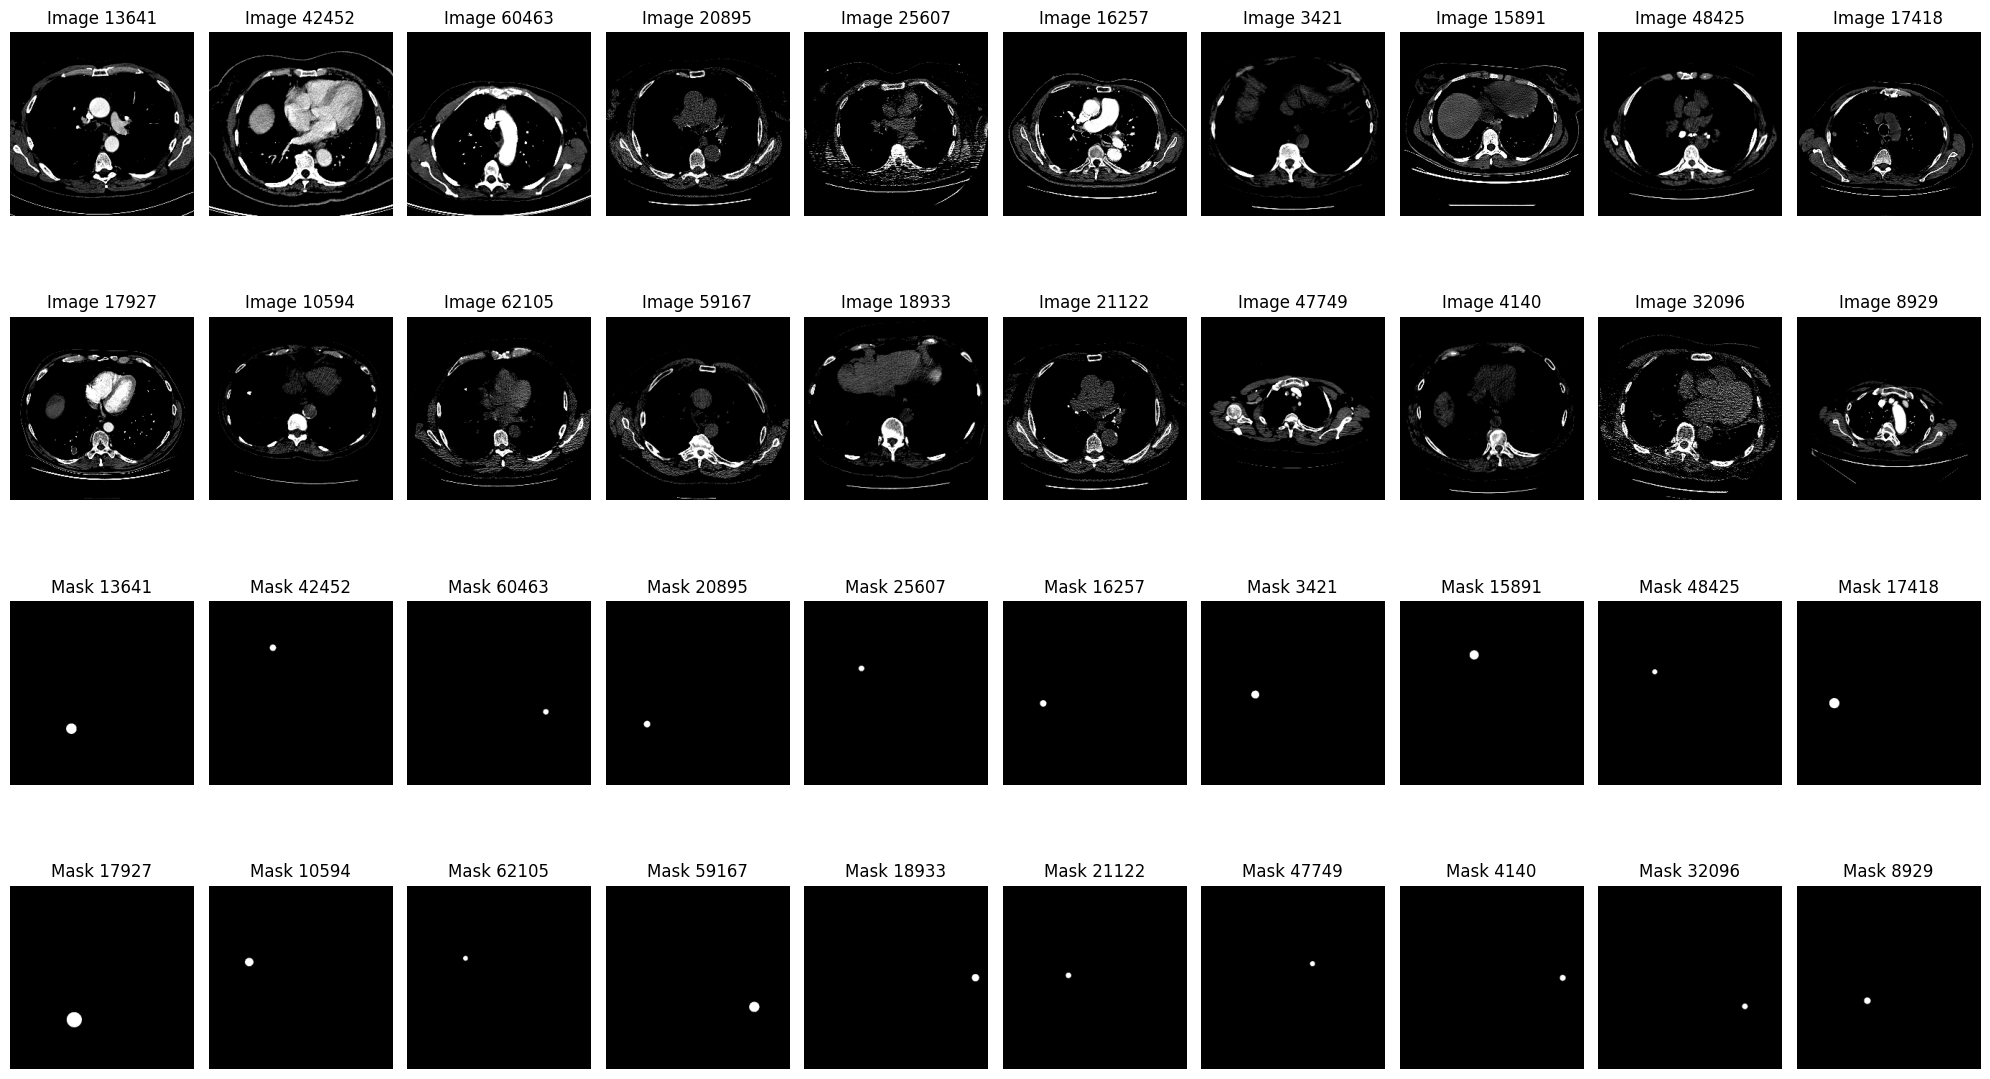

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

def preprocess_image(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)  # Add channel dimension if missing
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)  # Convert grayscale to RGB by repeating the channel
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0,1] range
    return image

def preprocess_mask(mask):
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension if missing
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32)
    return mask  # Ensure mask has shape (height, width, 1)

def clip_data(data):
    return np.clip(data, 0, 1)

def visualize_data(images, masks, indices):
    plt.figure(figsize=(20, 12))
    num_images = min(20, len(images))
    mask_info = []

    for i in range(num_images):
        has_nodule = np.any(masks[i] > 0)
        mask_info.append(has_nodule)

        # Display image
        plt.subplot(4, 10, i + 1)
        plt.imshow(clip_data(np.squeeze(images[i])), cmap="gray", vmin=0, vmax=1)
        plt.title(f"Image {indices[i]}")
        plt.axis("off")

        # Display mask
        plt.subplot(4, 10, i + 1 + 20)
        plt.imshow(clip_data(np.squeeze(masks[i])), cmap="gray", vmin=0, vmax=1)
        plt.title(f"Mask {indices[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Print summary of masks
    for i, has_nodule in enumerate(mask_info):
        print(f"Mask {indices[i]} contains nodule: {has_nodule}")

# Modify the data generator to shuffle and pick 20 random samples with nodules
def random_data_generator(df, batch_size=20):
    df_with_nodules = df[df['class'] == 1]
    indices = np.random.choice(df_with_nodules.index, batch_size, replace=False)
    batch_df = df.loc[indices]
    images = np.array([preprocess_image(img) for img in batch_df['imagedata']])
    masks = np.array([preprocess_mask(mask) for mask in batch_df['maskdata']])
    return images, masks, indices
# Data generator for training
def data_generator(df, batch_size=32, shuffle=True):
    indices = np.arange(len(df))
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        batch_indices = indices[start_idx:end_idx]
        batch_df = df.iloc[batch_indices]
        images = np.array([preprocess_image(img) for img in batch_df['imagedata']])
        masks = np.array([preprocess_mask(mask) for mask in batch_df['maskdata']])
        yield images, (masks, masks)

batch_size = 16
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df_slices, batch_size=batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
        (tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32))
    )
).prefetch(tf.data.experimental.AUTOTUNE)
# Manually trigger the generator to visualize the data
images, masks, indices = random_data_generator(df_slices, batch_size=20)
visualize_data(images, masks, indices)


In [ ]:
# Model Definition
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import SGD

###########################BACKBONE##############################################
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

first_conv_layer = base_model.layers[1]
weights, biases = first_conv_layer.get_weights()
summed_weights = np.sum(weights, axis=2, keepdims=True)
adjusted_weights = np.repeat(summed_weights, 3, axis=2)
first_conv_layer.set_weights([adjusted_weights, biases])

######################NECK##########################################################
# Feature Pyramid Network implementation
feature_c3 = base_model.get_layer('block3_conv3').output
feature_c4 = base_model.get_layer('block4_conv3').output
feature_c5 = base_model.get_layer('block5_conv3').output
up_c5 = UpSampling2D(size=(4, 4))(feature_c5)
up_c4 = UpSampling2D(size=(2, 2))(feature_c4)
concatenated_features = Concatenate()([up_c5, up_c4, feature_c3])

# Final feature map for predictions
fpn_features = Conv2D(256, kernel_size=3, padding='same', activation='relu')(concatenated_features)
fpn_features = BatchNormalization()(fpn_features)

###########################################HEAD##################################
# Binary classification (nodule/no nodule)
num_classes = 2
boxes_per_cell = 1  # Assuming one box per cell for simplicity

classification_head = Conv2D(num_classes, kernel_size=1, activation='sigmoid', name='classification_head')(fpn_features)
classification_head = UpSampling2D(size=(4, 4), name='up_classification')(classification_head)  # Upsample to match input size

box_regression_head = Conv2D(4 * boxes_per_cell, kernel_size=1, name='box_regression_head')(fpn_features)
box_regression_head = UpSampling2D(size=(4, 4), name='up_box_regression')(box_regression_head)  # Upsample to match input size

# Create the full model
inputs = base_model.input
outputs = [classification_head, box_regression_head]
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
              loss={'up_classification': 'binary_crossentropy', 'up_box_regression': 'mse'},
              metrics={'up_classification': 'accuracy', 'up_box_regression': 'mse'})

model.summary()



Mask 13641 contains nodule: True
Mask 42452 contains nodule: True
Mask 60463 contains nodule: True
Mask 20895 contains nodule: True
Mask 25607 contains nodule: True
Mask 16257 contains nodule: True
Mask 3421 contains nodule: True
Mask 15891 contains nodule: True
Mask 48425 contains nodule: True
Mask 17418 contains nodule: True
Mask 17927 contains nodule: True
Mask 10594 contains nodule: True
Mask 62105 contains nodule: True
Mask 59167 contains nodule: True
Mask 18933 contains nodule: True
Mask 21122 contains nodule: True
Mask 47749 contains nodule: True
Mask 4140 contains nodule: True
Mask 32096 contains nodule: True
Mask 8929 contains nodule: True
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0      

In [ ]:
import tensorflow as tf
import numpy as np

train_df = df_slices.sample(frac=0.8, random_state=42)
val_df = df_slices.drop(train_df.index)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df, batch_size=batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        (tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32))
    )
).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, batch_size=batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        (tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32))
    )
).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)  # Increase epochs for potentially better accuracy

# Evaluate the model
eval_results = model.evaluate(val_dataset)
print("Loss, Classification Accuracy, Bounding Box MSE:", eval_results)


Epoch 1/20
1715/1715 [==============================] - 959s 543ms/step - loss: 0.5741 - up_classification_loss: 0.4920 - up_box_regression_loss: 0.0821 - up_classification_accuracy: 0.4749 - up_box_regression_mse: 0.0821 - val_loss: 0.3423 - val_up_classification_loss: 0.3197 - val_up_box_regression_loss: 0.0226 - val_up_classification_accuracy: 0.4496 - val_up_box_regression_mse: 0.0226
Epoch 2/20
1715/1715 [==============================] - 913s 533ms/step - loss: 0.2461 - up_classification_loss: 0.2302 - up_box_regression_loss: 0.0160 - up_classification_accuracy: 0.4321 - up_box_regression_mse: 0.0160 - val_loss: 0.1757 - val_up_classification_loss: 0.1641 - val_up_box_regression_loss: 0.0117 - val_up_classification_accuracy: 0.4195 - val_up_box_regression_mse: 0.0117
Epoch 3/20
1715/1715 [==============================] - 914s 533ms/step - loss: 0.1363 - up_classification_loss: 0.1262 - up_box_regression_loss: 0.0100 - up_classification_accuracy: 0.4142 - up_box_regression_mse: 0

KeyboardInterrupt: 